In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, concatenate,Dropout,Multiply, Dense, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import MeanSquaredError

l = '/content/drive/MyDrive/Train/low'
h = '/content/drive/MyDrive/Train/high'

def load_images_from_directory(a):
    images = []
    for i in sorted(os.listdir(a)):
        img = cv2.imread(os.path.join(a, i))
        img = cv2.resize(img, (128, 128))
        images.append(img)
    return np.array(images)

low_images = load_images_from_directory(l) / 255.0
high_images = load_images_from_directory(h) / 255.0

X_train, X_test, y_train, y_test = train_test_split(low_images, high_images, test_size=0.2, random_state=42)

In [ ]:
# Structural Similarity Index Measure (SSIM) loss
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Combined loss
def combined_loss(y_true, y_pred):
    mse = MeanSquaredError()(y_true, y_pred)
    s_loss = ssim_loss(y_true, y_pred)
    return mse + 0.5 * s_loss

def residual_dense_block(x, filters, kernel_size=3, dropout_rate=0.3):
    res = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)
    res = Dropout(dropout_rate)(res)
    res = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(1e-4))(res)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)
    res = Dropout(dropout_rate)(res)
    res = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(1e-4))(res)
    res = BatchNormalization()(res)
    res = Add()([res, x])
    return res

def attention_block(x, filters):
    f = Conv2D(filters // 8, (1, 1), padding='same')(x)
    f = BatchNormalization()(f)
    f = Activation('relu')(f)

    g = Conv2D(filters // 8, (1, 1), padding='same')(x)
    g = BatchNormalization()(g)
    g = Activation('relu')(g)

    h = Conv2D(filters, (1, 1), padding='same')(x)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    s = Multiply()([f, g])
    beta = Activation('softmax')(s)
    beta = Conv2D(filters, (1, 1), padding='same')(beta)
    o = Multiply()([beta, h])
    return Add()([x, o])

def unet_residual_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = residual_dense_block(c1, 64)
    c1 = attention_block(c1, 64)
    p1 = Conv2D(64, (2, 2), strides=(2, 2), padding='same')(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = residual_dense_block(c2, 128)
    c2 = attention_block(c2, 128)
    p2 = Conv2D(128, (2, 2), strides=(2, 2), padding='same')(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = residual_dense_block(c3, 256)
    c3 = attention_block(c3, 256)
    p3 = Conv2D(256, (2, 2), strides=(2, 2), padding='same')(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = residual_dense_block(c4, 512)
    c4 = attention_block(c4, 512)
    p4 = Conv2D(512, (2, 2), strides=(2, 2), padding='same')(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = residual_dense_block(c5, 1024)
    c5 = attention_block(c5, 1024)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = residual_dense_block(c6, 512)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = residual_dense_block(c7, 256)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = residual_dense_block(c8, 128)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = residual_dense_block(c9, 64)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    return Model(inputs, outputs)

input_shape = X_train.shape[1:]  # height, width, channels
unet_residual = unet_residual_model(input_shape)
unet_residual.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss,metrics=['mse'])

# Callbacks
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.weights.h5', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-9)

history = unet_residual.fit(X_train, y_train, epochs=120,batch_size=10,validation_data=(X_test, y_test),
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])
predictions = unet_residual.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
print(f'Mean Squared Error: {mse}')

def calculate_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

# Calculate PSNR for the entire test set
psnr = calculate_psnr(y_test, predictions)
print(f'PSNR: {psnr}')

Epoch 1/120
39/39 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 1.3224 - mse: 0.0672 - val_loss: 1.1919 - val_mse: 0.0528 - learning_rate: 1.0000e-04
Epoch 2/120
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 628ms/step - loss: 1.0408 - mse: 0.0372 - val_loss: 1.1190 - val_mse: 0.0568 - learning_rate: 1.0000e-04
Epoch 3/120
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 447ms/step - loss: 0.9130 - mse: 0.0254 - val_loss: 1.0498 - val_mse: 0.0616 - learning_rate: 1.0000e-04
Epoch 4/120
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 437ms/step - loss: 0.8252 - mse: 0.0252 - val_loss: 0.9712 - val_mse: 0.0540 - learning_rate: 1.0000e-04
Epoch 5/120
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 487ms/step - loss: 0.7454 - mse: 0.0224 - val_loss: 0.9058 - val_mse: 0.0503 - learning_rate: 1.0000e-04
Epoch 6/120
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - loss: 0.6777 - mse: 0.0209 - val_loss: 0.8505 - val_mse: 0.0505 - learning_rate: 1.0000e-04
Epoch 7/120
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 446ms/step - loss: 0.6154 - mse: 0.0184 - val_loss: 0.7868 - val_mse: 0

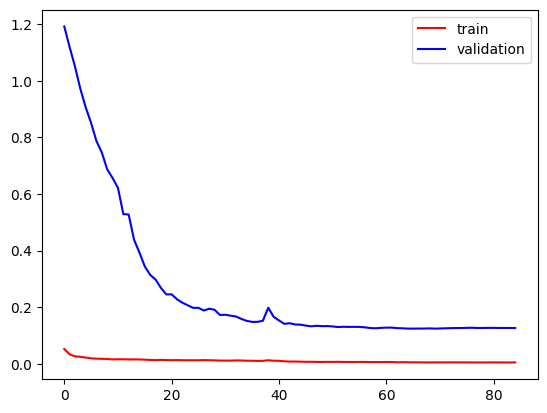

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mse'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

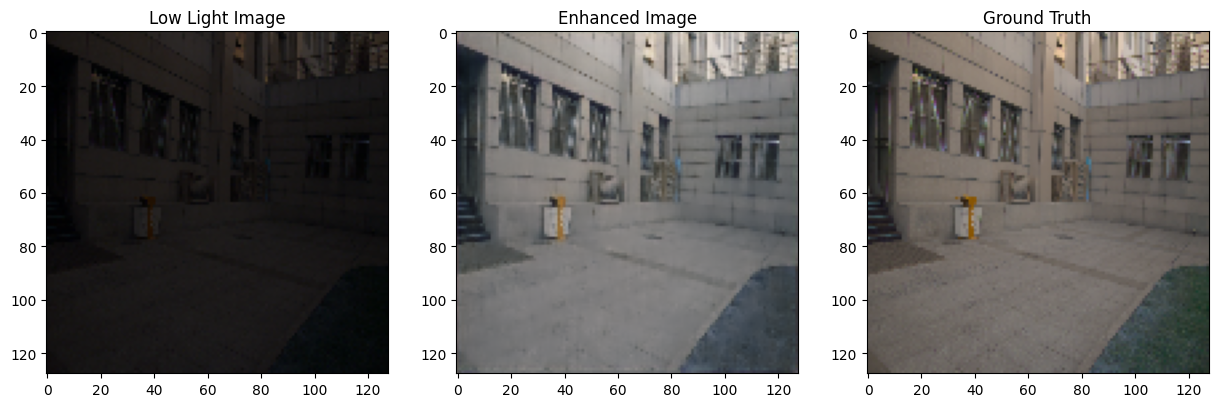

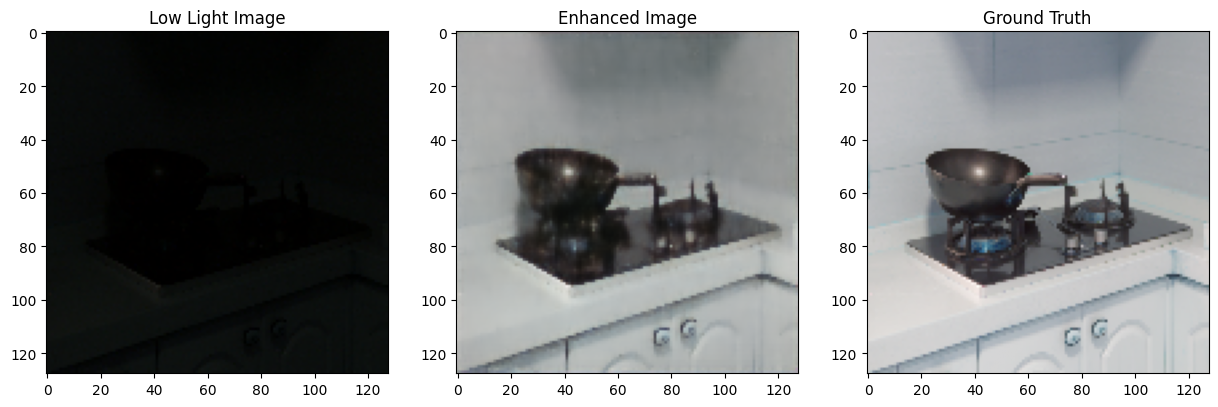

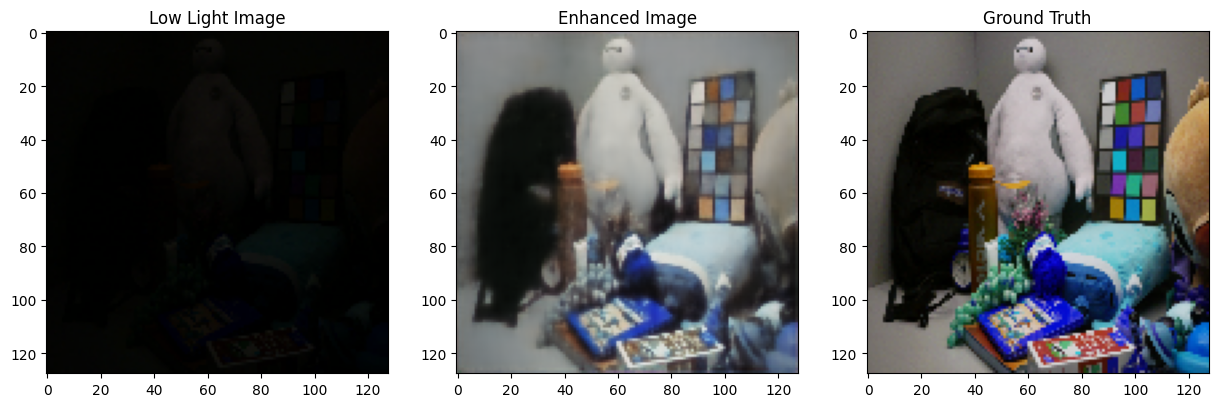

In [ ]:
# Display some results
for i in range(3):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Low Light Image')
    plt.imshow(X_test[i])
    plt.subplot(1, 3, 2)
    plt.title('Enhanced Image')
    plt.imshow(predictions[i])
    plt.subplot(1, 3, 3)
    plt.title('Ground Truth')
    plt.imshow(y_test[i])
    plt.show()